# GeneticFeatureSelectorNode

Whereas the `FSSNode` selects from a predefined list of subsets of features, the `GeneticFeatureSelectorNode` uses evolutionary algorithms to optimize a novel subset of features from scratch. This is useful where there is no predefined grouping of features. 

To initalize the `GeneticFeatureSelectorNode` you simply need to pass in the total number of features (i.e number of columns) in your dataset.

For these examples, we create a dummy dataset where the first six columns are informative and the rest are uninformative.

In [1]:
import tpot
from tpot.search_spaces.nodes import *
from tpot.search_spaces.pipelines import *
import tpot
import sklearn.datasets
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import tpot
import sklearn.datasets
from sklearn.linear_model import LogisticRegression
import numpy as np
from tpot.search_spaces.nodes import *
from tpot.search_spaces.pipelines import *
from tpot.config import get_search_space


X, y = sklearn.datasets.make_classification(n_samples=1000, n_features=6, n_informative=6, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
X = np.hstack([X, np.random.rand(X.shape[0],6)]) #add six uninformative features
X = pd.DataFrame(X, columns=['a','b','c','d','e','f','g','h','i', 'j', 'k', 'l']) # a, b ,c the rest are uninformative
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.75, test_size=0.25)

X.head()

/opt/anaconda3/envs/tpotenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,a,b,c,d,e,f,g,h,i,j,k,l
0,0.431031,1.889841,0.403235,0.130347,1.245051,-3.356587,0.254612,0.477369,0.145158,0.633607,0.200373,0.037735
1,0.016308,-1.035908,-1.625176,1.803391,0.442258,-0.844052,0.141507,0.024659,0.769976,0.658990,0.971987,0.570931
2,3.769469,0.209185,-1.303033,4.077509,2.935603,1.243487,0.088988,0.377935,0.019007,0.923725,0.760895,0.316752
3,-2.583292,0.172831,-1.531697,-0.078774,1.656190,0.475652,0.741539,0.179612,0.993759,0.624101,0.290679,0.946652
4,-0.833504,3.209340,-0.928798,0.345765,1.599057,0.242801,0.359656,0.697036,0.643063,0.198362,0.725530,0.974992


In [2]:
gfs_sp = GeneticFeatureSelectorNode(n_features=X.shape[1])

Each GeneticFeatureSelectorNode will select a new subset of features

In [3]:
selector = gfs_sp.generate().export_pipeline()
selector.set_output(transform="pandas") #by default sklearn selectors return numpy arrays. this will make it return pandas dataframes
selector.fit(X_train, y_train)
selector.transform(X_train)

,b,j
89,0.067735,0.839366
897,-0.175982,0.050951
824,-0.503185,0.826335
305,2.775297,0.877498
774,3.143969,0.429360
...,...,...
310,1.402502,0.506769
333,2.384090,0.047125
259,5.262763,0.500726
30,1.107717,0.768569


In [4]:
selector = gfs_sp.generate().export_pipeline()
selector.set_output(transform="pandas") #by default sklearn selectors return numpy arrays. this will make it return pandas dataframes
selector.fit(X_train, y_train)
selector.transform(X_train)

,k
89,0.179639
897,0.430166
824,0.354605
305,0.949369
774,0.499857
...,...
310,0.624468
333,0.995309
259,0.138835
30,0.548930


Mutation and crossover can add or remove subsets from the learned feature set.

In [5]:
selector_ind = gfs_sp.generate()
selector = selector_ind.export_pipeline()
selected_features = X.columns[selector.mask]

print("selected features: ", selected_features)

selected features:  Index(['a', 'j'], dtype='object')


In [6]:
selector_ind.mutate()
selector = selector_ind.export_pipeline()
selected_features = X.columns[selector.mask]
print("selected features: ", selected_features)

selected features:  Index(['a', 'h', 'j'], dtype='object')


## Training

In [7]:
import tpot
import sklearn.datasets
from sklearn.linear_model import LogisticRegression
import numpy as np
from tpot.search_spaces.nodes import *
from tpot.search_spaces.pipelines import *

gfs_sp = GeneticFeatureSelectorNode(n_features=X.shape[1])
classifiers_sp = get_search_space('RandomForestClassifier')
final_classification_search_space = SequentialPipeline([gfs_sp, classifiers_sp])

est = tpot.TPOTEstimator(  population_size=32,
                            generations=10, 
                            scorers=["roc_auc_ovr", tpot.objectives.complexity_scorer],
                            scorers_weights=[1.0, -1.0],
                            n_jobs=32,
                            classification=True,
                            search_space = final_classification_search_space,
                            verbose=1,
                            )


scorer = sklearn.metrics.get_scorer('roc_auc_ovo')

est.fit(X_train, y_train)
print(scorer(est, X_test, y_test))

/Users/ketrong/Desktop/tpotvalidation/tpot/tpot/tpot_estimator/estimator.py:456: UserWarning: Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.
  warnings.warn("Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.")
Generation: 100%|██████████| 10/10 [00:53<00:00,  5.33s/it]


0.9458645653148825


In [8]:
est.fitted_pipeline_

Pipeline(steps=[('maskselector',
                 MaskSelector(mask=array([ True,  True,  True,  True,  True,  True, False, False,  True,
       False,  True,  True]))),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy',
                                        max_features=0.487196536075,
                                        min_samples_leaf=5, min_samples_split=3,
                                        n_estimators=128, n_jobs=1))])

In [9]:
selected_features = X.columns[est.fitted_pipeline_.steps[0][1].mask]
print("selected features: ", selected_features)

selected features:  Index(['a', 'b', 'c', 'd', 'e', 'f', 'i', 'k', 'l'], dtype='object')


## Custom objective function to minimize number of selected features
We can create a custom objective function that returns the number of features selected per pipeline. The `other_objective_functions` parameter is for objective functions that do not require fitted pipelines and do not require cross validation. Since we know that the selector instance gets its features from its parameters, not through fitting, we can create an objective for the `other_objective_functions` parameter. 
We set the weights to -1 because we would like to minimize the number of features selected. We also give it a name so that we can more easily access it in the `evaluated_individuals` dataframe.

In [10]:
def number_of_selected_features(est):
   return sum(est.steps[0][1].mask)

gfs_sp = GeneticFeatureSelectorNode(n_features=X.shape[1])
classifiers_sp = get_search_space('RandomForestClassifier')
final_classification_search_space = SequentialPipeline([gfs_sp, classifiers_sp])

est = tpot.TPOTEstimator(  
                           population_size=32,
                           generations=10, 
                           scorers=["roc_auc_ovr", tpot.objectives.complexity_scorer],
                           scorers_weights=[1.0, -1.0],
                           other_objective_functions=[number_of_selected_features],
                           other_objective_functions_weights = [-1],
                           objective_function_names = ["Number of selected features"],

                           n_jobs=32,
                           classification=True,
                           search_space = final_classification_search_space,
                           verbose=2,
                            )

scorer = sklearn.metrics.get_scorer('roc_auc_ovo')

est.fit(X_train, y_train)
print(scorer(est, X_test, y_test))

/Users/ketrong/Desktop/tpotvalidation/tpot/tpot/tpot_estimator/estimator.py:456: UserWarning: Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.
  warnings.warn("Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.")
Generation: 100%|██████████| 10/10 [00:47<00:00,  4.73s/it]


0.9414440386956244


In [11]:
selected_features = X.columns[est.fitted_pipeline_.steps[0][1].mask]
print("selected features: ", selected_features)

selected features:  Index(['b', 'c', 'd', 'e', 'f', 'g'], dtype='object')


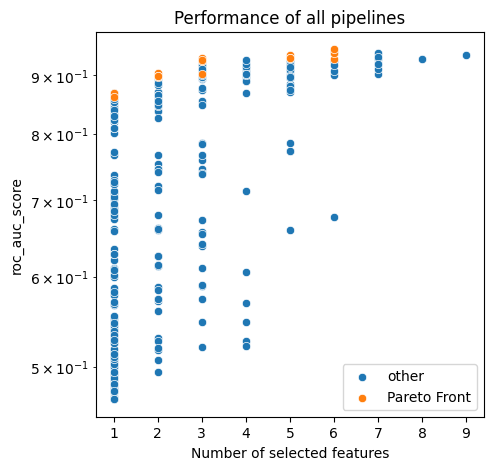

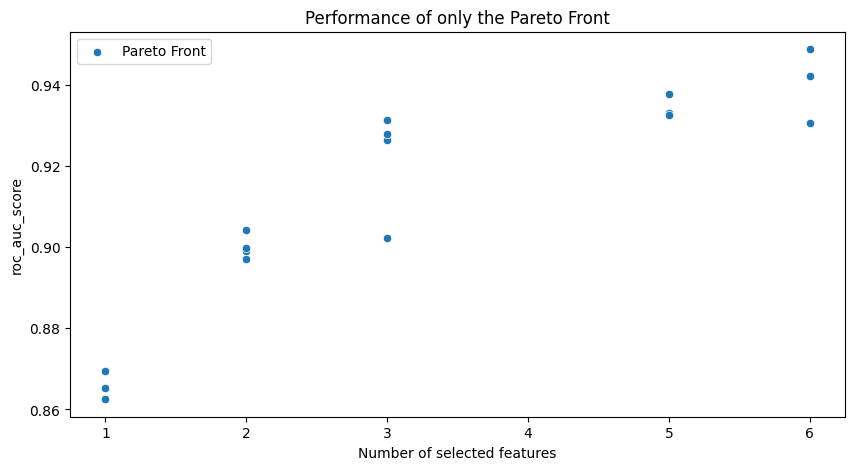

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

df = est.evaluated_individuals
col1 = "Number of selected features"
col2 = "roc_auc_score"

# Multiple orange dots show because the pareto front in this case is actually 3D along the auroc score, number of features, and complexity.

#replace nans in pareto front with 0
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(df[df['Pareto_Front']!=1], x=col1, y=col2, label='other', ax=ax)
sns.scatterplot(df[df['Pareto_Front']==1], x=col1, y=col2, label='Pareto Front', ax=ax)
ax.title.set_text('Performance of all pipelines')
#log scale y
ax.set_yscale('log')
plt.show()

#replace nans in pareto front with 0
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(df[df['Pareto_Front']==1], x=col1, y=col2, label='Pareto Front', ax=ax)
ax.title.set_text('Performance of only the Pareto Front')
#log scale y
# ax.set_yscale('log')
plt.show()

# Other Examples

As with all search spaces, GeneticFeatureSelectorNode can be combined with any other search space. 

You can also pair this with the existing prebuilt templates, for example:

In [13]:
linear_search_space = tpot.config.template_search_spaces.get_template_search_spaces("linear", classification=True)
gfs_and_linear_search_space = SequentialPipeline([gfs_sp, linear_search_space])

# est = tpot.TPOTEstimator(  
#                            population_size=32,
#                            generations=10, 
#                            scorers=["roc_auc_ovr", tpot.objectives.complexity_scorer],
#                            scorers_weights=[1.0, -1.0],
#                            other_objective_functions=[number_of_selected_features],
#                            other_objective_functions_weights = [-1],
#                            objective_function_names = ["Number of selected features"],

#                            n_jobs=32,
#                            classification=True,
#                            search_space = gfs_and_linear_search_space,
#                            verbose=2,
#                             )

gfs_and_linear_search_space.generate(rng=1).export_pipeline()

Pipeline(steps=[('maskselector',
                 MaskSelector(mask=array([False, False,  True, False, False, False, False, False, False,
        True, False, False]))),
                ('pipeline',
                 Pipeline(steps=[('normalizer', Normalizer(norm='l1')),
                                 ('selectpercentile',
                                  SelectPercentile(percentile=74.2561844719571)),
                                 ('featureunion-1',
                                  FeatureUnion(transformer_list=[('featureunion',
                                                                  FeatureUnion(transformer_list=[('binarizer',
                                                                                                  Binarizer(threshold=0.0935770250992))])),
                                                                 ('passthrough',
                                                                  Passthrough())])),
                                 ('featureunion-2',
                                  FeatureUnion(transformer_list=[('skiptransformer',
                                                                  SkipTransformer()),
                                                                 ('passthrough',
                                                                  Passthrough())])),
                                 ('adaboostclassifier',
                                  AdaBoostClassifier(algorithm='SAMME',
                                                     learning_rate=0.9665397922726,
                                                     n_estimators=320))]))])

### Getting Fancy

If you want to get fancy, you can combine more search spaces in order to set up unique preprocessing pipelines per feature set. Here's an example:

In [14]:
dynamic_transformers = DynamicUnionPipeline(get_search_space("all_transformers"), max_estimators=4)
dynamic_transformers_with_passthrough = tpot.search_spaces.pipelines.UnionPipeline([
    dynamic_transformers,
    tpot.config.get_search_space("Passthrough")],
    )
multi_step_engineering = DynamicLinearPipeline(dynamic_transformers_with_passthrough, max_length=4)
gfs_engineering_search_space = SequentialPipeline([gfs_sp, multi_step_engineering])
union_fss_engineering_search_space = DynamicUnionPipeline(gfs_engineering_search_space)
classification_search_space = get_search_space('classifiers')

final_fancy_search_space = SequentialPipeline([union_fss_engineering_search_space, classification_search_space])

final_fancy_search_space.generate(rng=1).export_pipeline()

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline',
                                                 Pipeline(steps=[('maskselector',
                                                                  MaskSelector(mask=array([False,  True, False, False, False, False, False, False,  True,
       False, False, False]))),
                                                                 ('pipeline',
                                                                  Pipeline(steps=[('featureunion-1',
                                                                                   FeatureUnion(transformer_list=[('featureunion',
                                                                                                                   FeatureUnion(transformer_list=[('robustscaler',
                                                                                                                                                   Robu...
                                                                                   FeatureUnion(transformer_list=[('featureunion',
                                                                                                                   FeatureUnion(transformer_list=[('normalizer',
                                                                                                                                                   Normalizer(norm='l1')),
                                                                                                                                                  ('nystroem',
                                                                                                                                                   Nystroem(gamma=0.5186832611359,
                                                                                                                                                            kernel='polynomial',
                                                                                                                                                            n_components=3))])),
                                                                                                                  ('passthrough',
                                                                                                                   Passthrough())]))]))]))])),
                ('sgdclassifier',
                 SGDClassifier(alpha=0.0024802032445, eta0=0.2824117602653,
                               l1_ratio=0.281711265998, loss='modified_huber',
                               n_jobs=1, penalty='elasticnet'))])